<a href="https://colab.research.google.com/github/Danny-L1u/AI_Vision/blob/main/Danny_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image search with 🤗 datasets

🤗 [`datasets`](https://huggingface.co/docs/datasets/) is a library that makes it easy to access and share datasets. It also makes it easy to process data efficiently - including working with data which doesn't fit into memory. 

When `datasets` was first launched it was more usually associated with text data. However, recently, `datasets` has added increased support for images. In particular there is now a `datasets` [feature type for images](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=image#datasets.Image). A previous [blog post](https://huggingface.co/blog/fine-tune-vit) showed how `datasets` can be used with 🤗 `transformers` to train an image classification model. In this blog post we'll see how we can combine `datasets` and a few other libraries to create an image search application. 

First, we'll install `datasets`. Since we're going to be working with images, we'll also install [`pillow`](https://pillow.readthedocs.io/en/stable/). We'll also need `sentence_transformers` and `faiss`. We'll introduce those in more detail below. We'll also install [`rich`](https://github.com/Textualize/rich) - we'll only briefly use it here, but it's a super handy package to have around — I'd really recommend exploring it further! 

In [1]:
%%capture
!pip install datasets pillow rich faiss-gpu sentence_transformers 


To start lets take a look at the image feature. We can use the wonderful [rich](https://rich.readthedocs.io/) library to poke around python objects (functions, classes etc.)

In [2]:
from rich import inspect
import datasets

In [3]:
inspect(datasets.Image, help=True)

╭──────────────────────────────────── <class 'datasets.features.image.Image'> ────────────────────────────────────╮
│ class Image(decode: bool = True, id: Union[str, NoneType] = None) -> None:                                      │
│                                                                                                                 │
│ Image feature to read image data from an image file.                                                            │
│                                                                                                                 │
│ Input: The Image feature accepts as input:                                                                      │
│ - A :obj:`str`: Absolute path to the image file (i.e. random access is allowed).                                │
│ - A :obj:`dict` with the keys:                                                                                  │
│                                                                                                                 │
│     - path: String with relative path of the image file to the archive file.                                    │
│     - bytes: Bytes of the image file.                                                                           │
│                                                                                                                 │
│   This is useful for archived files with sequential access.                                                     │
│                                                                                                                 │
│ - An :obj:`np.ndarray`: NumPy array representing an image.                                                      │
│ - A :obj:`PIL.Image.Image`: PIL image object.                                                                   │
│                                                                                                                 │
│ Args:                                                                                                           │
│     decode (:obj:`bool`, default ``True``): Whether to decode the image data. If `False`,                       │
│         returns the underlying dictionary in the format {"path": image_path, "bytes": image_bytes}.             │
│                                                                                                                 │
│ Examples:                                                                                                       │
│                                                                                                                 │
│ ```py                                                                                                           │
│ >>> from datasets import load_dataset, Image                                                                    │
│ >>> ds = load_dataset("beans", split="train")                                                                   │
│ >>> ds.features["image"]                                                                                        │
│ Image(decode=True, id=None)                                                                                     │
│ >>> ds[0]["image"]                                                                                              │
│ <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x15E52E7F0>                                  │
│ >>> ds = ds.cast_column('image', Image(decode=False))                                                           │
│ {'bytes': None,                                                                                                 │
│  'path':                                                                                                        │
│ '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0 │
│ f0bc1292/train/healthy/healthy_train.85.jpg'}         



We can see there a few different ways in which we can pass in our images. We'll come back to this in a little while. 

A really nice feature of the `datasets` library (beyond the functionality for processing data, memory mapping etc.) is that you get some nice things 'for free'. One of these is the ability to add a [`faiss`](https://github.com/facebookresearch/faiss) index to a dataset. [ `faiss`](https://github.com/facebookresearch/faiss)  is a ["library for efficient similarity search and clustering of dense vectors"](https://github.com/facebookresearch/faiss). 

The `datasets` [docs](https://huggingface.co/docs/datasets) show an [example](https://huggingface.co/docs/datasets/faiss_es.html#id1) of using a `faiss` index for text retrieval. In this post we'll see if we can do the same for images. 

## The dataset: "Digitised Books - Images identified as Embellishments. c. 1510 - c. 1900. JPG"


This is a dataset of images which have been pulled from a collection of digitised books from the British Library. These images come from books across a wide time period and from a broad range of domains. The images were extracted using information contained in the OCR output for each book. As a result it's known which book the images came from but not 
necessarily anything else about that image i.e. what it is of. 

Some attempts to help overcome this have included uploading the images to [flickr](https://www.flickr.com/photos/britishlibrary/albums). This allows people to tag the images or put them into various different categories. 

There have also been projects to tag the dataset [using machine learning](https://blogs.bl.uk/digital-scholarship/2016/11/sherlocknet-update-millions-of-tags-and-thousands-of-captions-added-to-the-bl-flickr-images.html). This work already makes it possible to search by tags but we might want a 'richer' ability to search. For this particular experiment we'll work with a subset of the collections which contain "embellishments". This dataset is a bit smaller so will be better for experimenting with. We can get the full data from the British Library's data repository: [https://doi.org/10.21250/db17](https://doi.org/10.21250/db17). Since the full dataset is still fairly large we'll work with a smaller sample.

## Creating our dataset 

Our dataset consists of a folder containing subdirectories inside which are images. This is a fairly standard format for sharing image datasets. Thanks to a recently merged [pull request](https://github.com/huggingface/datasets/pull/2830) we can directly load this dataset using `datasets` `ImageFolder` loader 🤯


In [4]:
from datasets import load_dataset

In [5]:
# use https://bl.iro.bl.uk/downloads/ba1d1d12-b1bd-4a43-9696-7b29b56cdd20?locale=en if you want the full dataset
dataset = load_dataset("imagefolder", data_files="https://zenodo.org/record/6224034/files/embellishments_sample.zip?download=1")

Using custom data configuration default-87ea5bbdb5f10152


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-87ea5bbdb5f10152/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Let's see what we get back. 

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

We can get back a `DatasetsDict` and we have a `Dataset` with `image` and `label` features. 


Since we don't have any train/validation splits here let's just grab the `train` part of our dataset. 

In [7]:
dataset = dataset['train']

Let's also take a look at one example from our dataset to see what this looks like.

In [8]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=517x487 at 0x7FE711EB8990>,
 'label': 142}

Let's start with the label column. This contains the parent folder for our images in this case this represents the year of publication for the books from which the images are taken. We can see the mappings for this using  `dataset.features`


In [9]:
dataset.features['label']

ClassLabel(num_classes=210, names=['1540', '1593', '1602', '1607', '1623', '1630', '1631', '1633', '1634', '1635', '1636', '1637', '1638', '1639', '1640', '1641', '1643', '1648', '1656', '1661', '1662', '1664', '1665', '1670', '1675', '1681', '1683', '1688', '1689', '1690', '1691', '1695', '1704', '1710', '1714', '1716', '1717', '1718', '1719', '1720', '1721', '1722', '1723', '1724', '1725', '1727', '1728', '1729', '1730', '1731', '1732', '1733', '1734', '1735', '1736', '1737', '1738', '1739', '1740', '1742', '1743', '1744', '1746', '1747', '1748', '1749', '1750', '1751', '1753', '1754', '1755', '1756', '1757', '1759', '1760', '1761', '1762', '1765', '1766', '1767', '1768', '1769', '1770', '1771', '1772', '1773', '1774', '1775', '1776', '1777', '1778', '1780', '1781', '1782', '1783', '1785', '1787', '1788', '1789', '1791', '1792', '1794', '1795', '1796', '1797', '1798', '1800', '1801', '1802', '1803', '1804', '1805', '1806', '1807', '1809', '1810', '1811', '1812', '1814', '1815', '1816

In this particular dataset the image filenames also contains some metadata, in particular about the book from which the image was taken. There are a few ways we can get this information. 

When we look at one example from our dataset that the `image` feature was a `PIL.JpegImagePlugin.JpegImageFile`. Since `PIL.Images` have a filename attribute, one way in which we can grab our filenames is by accessing this. 

In [10]:
dataset[0]['image'].filename

'/root/.cache/huggingface/datasets/downloads/extracted/f324a87ed7bf3a6b83b8a353096fbd9500d6e7956e55c3d96d2b23cc03146582/embellishments_sample/1838/000541136_0_000029_1_[The Additional Annotations in the second edition of Bishop Burnet s History [i e  the Oxford edition of 1833]     accommodated to the pages of the first edition ]_1838.jpg'

In [11]:
dataset = dataset.map(lambda example: {"fname": example['image'].filename.split("/")[-1]})

  0%|          | 0/10000 [00:00<?, ?ex/s]

We can look at one example to see what this looks like. 

In [12]:
dataset[0]

{'fname': '000541136_0_000029_1_[The Additional Annotations in the second edition of Bishop Burnet s History [i e  the Oxford edition of 1833]     accommodated to the pages of the first edition ]_1838.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=517x487 at 0x7FE711B6C350>,
 'label': 142}

We've got our metadata now. Let's see some pictures already! If we access an example and index into the `image` column we'll see our image 😃

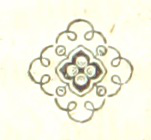

In [13]:
dataset[10]['image']

> **Note** in an [earlier version](https://danielvanstrien.xyz/metadata/deployment/huggingface/ethics/huggingface-datasets/faiss/2022/01/13/image_search.html) of this blog post the steps to download and load the images was much more convoluted. The new `ImageFolder` loader makes this process much easier 😀 In particular we didn't actually need to worry about how to load our images since `datasets` took care of this for us. 

## Push all the things to the hub! 

![Push all the things to the hub!](https://i.imgflip.com/613c0r.jpg)

One of the super awesome things about the 🤗 ecosystem is the huggingface hub. We can use the hub to access models and datasets. Often this is used for sharing work with others but it can also be a useful tool for work in progress. `datasets` recently added a `push_to_hub` method that allows you to push a dataset to the 🤗 hub with minimal fuss. This can be really helpful by allowing you to pass around a dataset with all the transforms etc. already done. 

For now we'll push the dataset to the hub and keep it private initially.

Depending on where you are running the code, you may need to authenticate. You can either do this using the `huggingface-cli login` command or, if you are running in a notebook, using `notebook_login`

In [14]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [17]:
dataset.push_to_hub('DannyL1u/embellishments-sample', private=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1951: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

> **Note**: in a [previous version](https://danielvanstrien.xyz/metadata/deployment/huggingface/ethics/huggingface-datasets/faiss/2022/01/13/image_search.html) of this blog post we had to do a few more steps to ensure images were included sucesfully when using `push_to_hub`. Thanks to [this pull request](https://github.com/huggingface/datasets/pull/3685) we no longer need to worry about these extra steps. We just need to make sure `embed_external_files=True` (which is the default behaviour).

### Switching machines

At this point I've created a dataset and moved it to the huggingface hub. This means it is possible to pickup the work/dataset elsewhere. 

In this particular example, having access to a GPU is important. Using the 🤗 hub as a way to pass around our data we could start on a laptop and pick up the work on Google Colab.

If we've moved to a new machine you may need to login again. Once we've done this we can load our dataset

In [18]:
from datasets import load_dataset

dataset = load_dataset("DannyL1u/embellishments-sample", use_auth_token=True)

Downloading:   0%|          | 0.00/6.38k [00:00<?, ?B/s]

Using custom data configuration DannyL1u--embellishments-sample-b56b45f6be584ba9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/DannyL1u___parquet/DannyL1u--embellishments-sample-b56b45f6be584ba9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## Creating embeddings 🕸

We now have a dataset with a bunch of images in it. To begin creating our image search app we need to create some embeddings for these images. There are various ways in which we can try and do this but one possible way is to use the clip models via the `sentence_transformers` library. The [clip model](https://openai.com/blog/clip/) from OpenAI learns a joint representation for both images and text which is very useful for what we want to do since we want to be able to input text and get back an image. 

We can download the model using the `SentenceTransformer` class. 

In [19]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-ViT-B-32')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


This model will take as input either an image or some text and return an embedding. We can use the `datasets` `map` method to encode all our images using this model. When we call map we return a dictionary with the key `embeddings` containing the embeddings returned by the embedding model. We also pass `device='cuda'` when we call model, this ensures that we're doing the encoding on the GPU.


In [20]:
ds_with_embeddings = dataset.map(
    lambda example: {'embeddings':model.encode(example['image'], device='cuda')}, batched=True, batch_size=32)

  0%|          | 0/313 [00:00<?, ?ba/s]

We can "save" our work by pushing back to the 🤗 hub using `push_to_hub`.

In [ ]:
ds_with_embeddings.push_to_hub('DannyL1u/embellishments-sample', private=True)

If we were to move to a different machine we could grab our work again by loading it from the hub 😃

In [ ]:
from datasets import load_dataset

ds_with_embeddings = load_dataset("DannyL1u/embellishments-sample", use_auth_token=True)

We now have a new column which contains the embeddings for our images. We could manually search through these and compare it to some input embedding but datasets has an `add_faiss_index` method. This uses the [faiss](https://github.com/facebookresearch/faiss) library to create an efficient index for searching embeddings. For more background on this library you can watch this [YouTube video](https://www.youtube.com/embed/sKyvsdEv6rk)

In [ ]:
ds_with_embeddings['train'].add_faiss_index(column='embeddings')

## Image search

> **Note** that these examples were generated from the full version of the dataset so you may get slightly different results. 

We now have everything we need to create a simple image search. We can use the same model we used to encode our images to encode some input text. This will act as the prompt we try and find close examples for. Let's start with 'a steam engine'. 

In [ ]:
prompt = model.encode("A steam engine")

We can see what this looks like

In [ ]:
prompt.shape

We can use another method from the datasets library `get_nearest_examples` to get images which have an embedding close to our input prompt embedding. We can pass in a number of results we want to get back. 

In [ ]:
scores, retrieved_examples = ds_with_embeddings['train'].get_nearest_examples('embeddings', prompt,k=9)

We can index into the first example this retrieves:

In [ ]:
retrieved_examples['img'][0]

This isn't quite a steam engine but it's also not a completely weird result. We can plot the other results to see what was returned. 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(20, 20))
columns = 3
for i in range(9):
    image = retrieved_examples['img'][i]
    plt.subplot(9 / columns + 1, columns, i + 1)
    plt.imshow(image)

Some of these results look fairly close to our input prompt. We can wrap this in a function so can more easily play around with different prompts

In [ ]:
def get_image_from_text(text_prompt, number_to_retrieve=9):
    prompt = model.encode(text_prompt)
    scores, retrieved_examples = ds_with_embeddings['train'].get_nearest_examples('embeddings', prompt,k=number_to_retrieve)
    plt.figure(figsize=(20, 20))
    columns = 3
    for i in range(9):
        image = retrieved_examples['img'][i]
        plt.title(text_prompt)
        plt.subplot(9 / columns + 1, columns, i + 1)
        plt.imshow(image)

In [ ]:
get_image_from_text("An illustration of the sun behind a mountain")

### Trying a bunch of prompts ✨

Now we have a function for getting a few results we can try a bunch of different prompts:

- For some of these I'll choose prompts which are a broad 'category' i.e. 'a musical instrument' or 'an animal', others are specific i.e. 'a guitar'. 

- Out of interest I also tried a boolean operator:  "An illustration of a cat or a dog". 

- Finally I tried something a little more abstract: "an empty abyss"

In [ ]:
prompts = ["A musical instrument", "A guitar", "An animal", "An illustration of a cat or a dog", "an empty abyss"]

In [ ]:
for prompt in prompts:
    get_image_from_text(prompt)

We can see these results aren't always right but they are usually some reasonable results in there. It already seems like this could be useful for searching for a the semantic content of an image in this dataset. However we might hold off on sharing this as is...

## Creating a huggingface space? 🤷🏼

One obvious next step for this kind of project is to create a hugginface [spaces](https://huggingface.co/spaces) demo. This is what I've done for other [models](https://huggingface.co/spaces/BritishLibraryLabs/British-Library-books-genre-classifier-v2)

It was a fairly simple process to get a [Gradio app setup](https://gradio.app/) from the point we got to here. Here is a screenshot of this app.  

![](https://github.com/davanstrien/blog/blob/master/images/spaces_image_search.png?raw=1)


However, I'm a little bit vary about making this public straightaway. Looking at the model card for the CLIP model we can look at the primary intended uses:

> ### Primary intended uses 
We primarily imagine the model will be used by researchers to better understand robustness, generalization, and other capabilities, biases, and constraints of computer vision models. [source](https://huggingface.co/openai/clip-vit-base-patch32)

This is fairly close to what we are interested in here. Particularly we might be interested in how well the model deals with the kinds of images in our dataset (illustrations from mostly 19th century books). The images in our dataset are (probably) fairly different from the training data. The fact that some of the images also contain text might help CLIP since it displays some [OCR ability](https://openai.com/blog/clip/). 

However, looking at the out-of-scope use cases in the model card:

> ### Out-of-Scope Use Cases
Any deployed use case of the model - whether commercial or not - is currently out of scope. Non-deployed use cases such as image search in a constrained environment, are also not recommended unless there is thorough in-domain testing of the model with a specific, fixed class taxonomy. This is because our safety assessment demonstrated a high need for task specific testing especially given the variability of CLIP’s performance with different class taxonomies. This makes untested and unconstrained deployment of the model in any use case currently potentially harmful. [source](https://huggingface.co/openai/clip-vit-base-patch32)

suggests that 'deployment' is not a good idea. Whilst the results I got are interesting I haven't played around with the model enough yet (and haven't done anything more systematic to evaluate its performance and biases). Another additional consideration is the target dataset itself. The images are drawn from books covering a variety of subjects and time periods. There are plenty of books which represent colonial attitudes and as a result some of the images included may represent certain groups of people in a negative way. This could potentially be a bad combo with a tool which allows any arbitrary text input to be encoded as a prompt.

There may be ways around this issue but this will require a bit more thought. 

 

## Conclusion 

Although we don't have a nice demo to show for it, we've seen how we can use `datasets` to:

- load images into the new `Image` feature type
- 'save' our work using `push_to_hub` and use this to move data between machines/sessions
- create a `faiss` index for images that we can use to retrieve images from a text (or image) input